In [2]:
#modules
import tensorflow as tf # ml
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard
import pickle # files
import time # inbuilt time
from tqdm import tqdm # loading percentage
import os # inbuilt os directories
import cv2 # photos
import numpy as np # arrays
import random # random number generation 
import matplotlib.pyplot as plt # graphs
import math # math operations

In [3]:
#file dir's
# done before pre processing
ROOT_DIR = os.getcwd()
IMAGES_DIR = ROOT_DIR + "/Dataset/Images/"
SAVE_DIR = ROOT_DIR + "/Dataset/load_data/"
TEST_DIR = ROOT_DIR + "/test/"
LR = 1e-3
RES = 3
VERSION = "1.0"
MODEL_NAME = "FOODCNN_{}.model".format(VERSION)
IMAGE_SIZE = 50

In [4]:
# Preprocess Data
# photos to number data (numpy array format)
def generate_dataset(IMAGES_DIR):
    data_set = []
    labels = os.listdir(IMAGES_DIR)
    ind = 0
    for dirs in labels:
        for img in tqdm(os.listdir(IMAGES_DIR+dirs+"/")):
            label = [0]*len(labels)
            label[labels.index(dirs)] = 1
            image_path = os.path.join(IMAGES_DIR+dirs+"/",img)
            image = cv2.resize(cv2.imread(image_path),(IMAGE_SIZE,IMAGE_SIZE))
            #color to black and white
            data_set.append([image,label])
    random.shuffle(data_set)
    np.save(os.path.join(SAVE_DIR,'data_set.npy'),data_set)
    return data_set

In [5]:
# Data set import
if 'data_set.npy' in os.listdir(SAVE_DIR):
    # reuse of data
    data_set = np.load(os.path.join(SAVE_DIR,'data_set.npy'))
    print("Data Set Loaded Successfully....")
else:
    data_set = generate_dataset(IMAGES_DIR)
    print("Data Set Created Successfully....")


Data Set Loaded Successfully....


In [6]:
# data set operations
train_percent = math.floor(0.8*len(data_set)) # 80% training
X = [i[0] for i in data_set[:train_percent]]
Y = [i[1] for i in data_set[:train_percent]]
X_TEST = [i[0] for i in data_set[train_percent:]] #20% testing
Y_TEST = [i[1] for i in data_set[train_percent:]]

# convert arrays to np arrays
X = np.array(X).reshape(-1,IMAGE_SIZE,IMAGE_SIZE,RES)
X_TEST = np.array(X_TEST).reshape(-1,IMAGE_SIZE,IMAGE_SIZE,RES)

Y = np.array(Y)
Y_TEST = np.array(Y_TEST)

# values between 0 to 255 to 0 to 1
X = X/255.0
X_TEST = X_TEST/255.0

print(X.shape)
print(X_TEST.shape)

(1404, 50, 50, 3)
(351, 50, 50, 3)


In [8]:
# Building a Neural Network

model = Sequential()

model.add(Conv2D(64, (5,5), activation = 'relu' , input_shape= X.shape[1:] ) )

model.add(MaxPooling2D(pool_size = (2,2) ))

model.add(Conv2D(64, (5,5), activation = 'relu' ))

model.add(MaxPooling2D(pool_size = (2,2) ))

model.add(Flatten())

model.add(Dense( 1000, activation = 'relu'))

model.add( Dropout(0.5) )

model.add(Dense( 500, activation = 'relu'))

model.add( Dropout(0.5) )

model.add(Dense( 250, activation = 'relu'))

model.add(Dense( len( os.listdir(IMAGES_DIR) ), activation = 'softmax'))

In [9]:
# Compiling the Model

model.compile(loss = "categorical_crossentropy" , optimizer = 'adam' , metrics = ["accuracy"])

In [11]:
# train model
if MODEL_NAME in os.listdir(SAVE_DIR):
    # already available
    model = tf.keras.models.load_model(SAVE_DIR+MODEL_NAME)
    print("Model Loaded Successfully....")
else:
    # train model
    hist = model.fit(X,Y
                    ,batch_size = 100
                    ,epochs = 10
                    ,validation_split = 0.2)
    model.save(SAVE_DIR+MODEL_NAME)
    print("Model Created Successfully....")

Model Loaded Successfully....


In [12]:
results = model.evaluate(X_TEST, Y_TEST, batch_size=128)

351/351 [==============================] - ETA: 4s - loss: 1.8963 - acc: 0.414 - ETA: 1s - loss: 1.8083 - acc: 0.457 - 3s 9ms/sample - loss: 1.7672 - acc: 0.4758


In [13]:
print("test loss, test acc:", results)

test loss, test acc: [1.7672077091331155, 0.47578347]


In [14]:
predictions = model.predict(X_TEST[:3])
print("predictions :", predictions)

predictions : [[1.0940333e-01 2.5510103e-01 4.6455402e-02 4.1435100e-02 5.4760516e-01]
 [1.8493769e-01 9.1177158e-02 4.3217443e-02 8.9750871e-02 5.9091681e-01]
 [2.3701172e-03 4.4055847e-03 9.7707558e-01 1.5818724e-02 3.3003575e-04]]


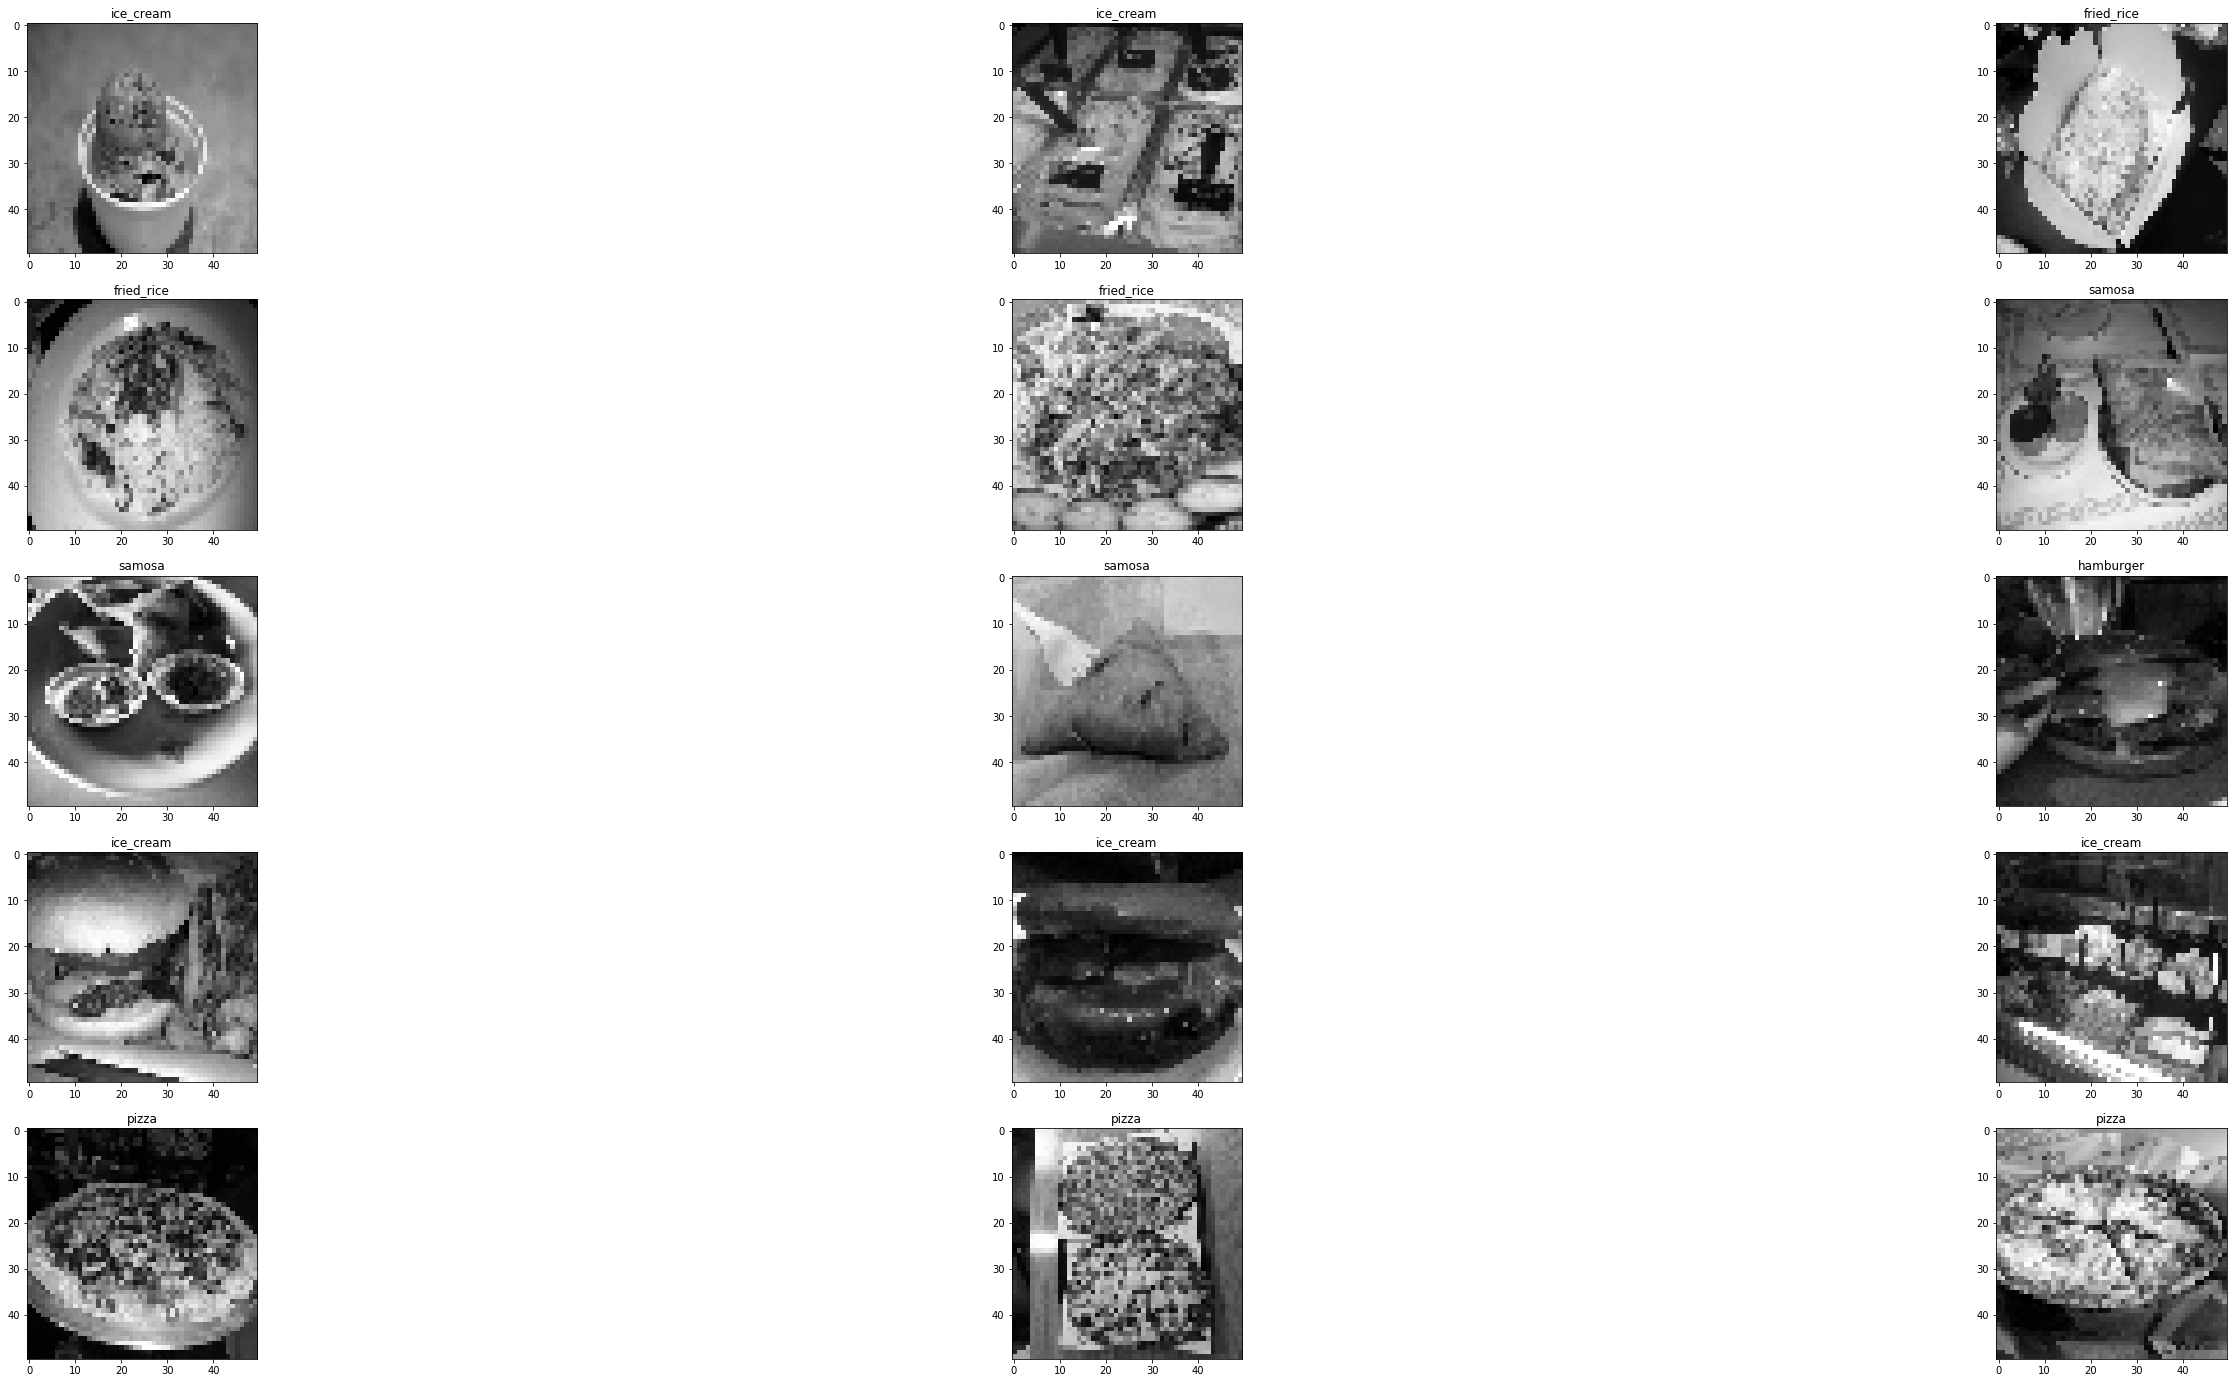

In [22]:
#Predict Food Image
def predict_food(TEST_DIR):
    predictions = []
    labels = os.listdir(IMAGES_DIR)
    for im in os.listdir(TEST_DIR):
        imag = cv2.resize(cv2.imread(os.path.join(TEST_DIR,im),cv2.IMREAD_GRAYSCALE),(IMAGE_SIZE,IMAGE_SIZE))
        image = cv2.resize(cv2.imread(os.path.join(TEST_DIR,im)),(IMAGE_SIZE,IMAGE_SIZE))
        image = np.array(image).reshape(-1,IMAGE_SIZE,IMAGE_SIZE,RES)
        image = image/255.0
        p = list(model.predict(image)[0])
        predictions.append([imag,labels[p.index(max(p))]])
    return predictions
x = predict_food(TEST_DIR)
# print(x)
fig = plt.figure(figsize=(50, 50))  # width, height in inches

for i in range(len(x)):
    sub = fig.add_subplot(10, 3, i + 1)
    sub.imshow(x[i][0],cmap="gray")
    sub.title.set_text(x[i][1])